<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Human-Innate-Immune-System" data-toc-modified-id="Human-Innate-Immune-System-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Human Innate Immune System</a></span></li></ul></div>

# Human Innate Immune System

Eplore how heat affects the human innate immune system. 

Important note: adding stochasticity to the ODE (SDE) makes it difficult to solve. Hence the scipy library may not handle this properly.

In [28]:
import sys
sys.path.append('../')

from scipy.interpolate import interp1d

import numpy as np
import scipy as s
import csv as c 
import seaborn as sns
import pandas as pd
import os
import scipy.integrate as spi
import matplotlib.pyplot as plt
import itertools
import pickle
import random

import Parameters as prms
import APPIREDII_Cytokines_Parser as cyto
import APPIREDII_Blood_Params_Parser as dp

from matplotlib import cm
# from tqdm import tqdm
"""
Code to model the innate immune response coupled with the Alkaline Phosphatase simulator.
Created on Thu Mar 10 11:24:36 2016. Runtime is in minutes.
"""

__author__ = "Louella Alva Presbitero"

sns.set_palette("deep")
sns.set_color_codes("deep")


def vectorfield(w, t, p, params):
    """
    Define differential equations for the innate immune system.

    Arguments:
        w : vector of the state variables
            w=[N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH,
            N_A, ND_A, ACH, ND_N]
        t : time
        p : vector of the parameters
    """
    global seed

    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH, N_A, ND_A, \
    ACH, ND_N = pre_vectorfield(w, params)

    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN, mu_NR, mu_ITM, \
    Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, \
    theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, \
    beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, \
    Pmax_APE, Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, \
    step_max, r_NDN, r_ITM, ITMblood_peak, r_AP, rinduce, ITM_source_peak, ITM_source_width, add_ITMblood, slow, t_add, \
    sig_mult, src_strength, src_width = p

    if noise_type == 'sigmoid':
        sum_added_ITMs = add_ITMblood * 1. / (1. + np.exp(slow * (t_add - t)))
        gauss_source = 0

    elif noise_type == 'gaussian':
        sum_added_ITMs = 0
        gauss_source = src_strength * np.exp(-(t - t_add)**2 /
                                             (2 * src_width**2))
    elif noise_type == 'linear':
        sum_added_ITMs = add_ITMblood
        gauss_source = 0
        
    elif noise_type == 'interval':
        sum_added_ITMs = add_ITMblood * 1. / (1. + np.exp(slow * (t_add - t)))
        gauss_source = 0
#         if t > t_add: 
#             sum_added_ITMs = 0

    if sigma_type == 'constant':
        sigma = sig_mult
    elif sigma_type == 'increasing':
        sigma = t * sig_mult
    else:
        sigma = 0
        

    noise = random.normalvariate(mu, sigma)

    hypothesis = 0
    CH_delay = 20
    NDA_delay = 5. * 60.
    delay_AP = 60.

    f_dillution = 1. / 16.  # (80/5) ratio betweenblood tissue compartment and blood compartment

    t_ITM = 10.
    t_ITM_source = 5. * 60.
    t_inject = 8. * 60.

    if params['h'] == 'h4':
        hypothesis = (rinduce_peak /
                      (1 + np.exp(rinduce *
                                  (t - delay_AP)))) * (AP_Sblood + AP_Stissue)

    hypothesis *= int(not (hypothesis < 0))

    if params['restrict']:
        source_ITM = ITM_source_peak * np.exp(-(1. / (2. *
                                                      (ITM_source_width**2))) *
                                              (t - t_ITM_source)**2)
    else:
        source_ITM = 0

    f = [
        # N_R
        -mu_NR * N_R - (Pmax_NR * (CH /
                                   (CH + Keq_CH))) * (1 - N_A / Nmax) * N_R +
        (r_Nhomeo * (1. - N_R / Nmax) * N_R) * (int(not (N_R < 0))),

        # AP_Eblood
        -mu_APE * AP_Eblood - lamb_APE * AP_Eblood * ITMblood -
        ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Eblood +
        (1. / (1. + np.exp(-r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min**2))) *
                                         (AP_Eblood + AP_Sblood)**2)),

        # AP_Etissue
        -mu_APE * AP_Etissue - lamb_APE * AP_Etissue * ITMtissue +
        f_dillution * ((Pmax_APE - Pmin_APE) *
                       (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Eblood,

        # AP_Eliver
        (1. / (1. + np.exp(-r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min**2))) *
                                         (AP_Eblood + AP_Sblood)**2)),

        # AP_Sblood
        (-mu_APS * AP_Sblood - lamb_APS * AP_Sblood * ITMblood + AP_Sinj *
         (1. / (1. + np.exp((step_max * (t - t_inject))))) -
         ((Pmax_APE - Pmin_APE) * (CH /
                                   (CH + Keq_CH)) + Pmin_APE) * AP_Sblood) *
        (int(not (AP_Sblood < 0))),

        # AP_Stissue
        -mu_APS * AP_Stissue - lamb_APS * AP_Stissue * ITMtissue +
        f_dillution * ((Pmax_APE - Pmin_APE) *
                       (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Sblood,

        # ITMblood
        (-mu_ITM * ITMblood - ITMblood *
         (lamb_APE * AP_Eblood + lamb_APS * AP_Sblood) -
         ((Pmax_ITM - Pmin_ITM) * (CH / (CH + Keq_CH)) + Pmin_ITM) * ITMblood *
         (1 - ITMtissue / ITMmax)) * (int(not (ITMblood < 0))) +
        ITMblood_peak * (1 - ITMblood / ITMmax) *
        (1. / (1. + np.exp(r_ITM * (t - t_ITM)))) + source_ITM +
        sum_added_ITMs + gauss_source + (noise) *
        (int(not (ITMblood < 0))
         )  # makes sure that the added noise does not make ITMs negative
        ,

        # ITMtissue
        (-mu_ITM * ITMtissue - ITMtissue *
         (lamb_APE * AP_Etissue + lamb_APS * AP_Stissue + lamb_ITMMA * M_A +
          lamb_ITMNDN * N_A) + alpha_ITMNDN * ND_N + f_dillution *
         ((Pmax_ITM - Pmin_ITM) * (CH / (CH + Keq_CH)) + Pmin_ITM) * ITMblood *
         (1. - ITMtissue / ITMmax)) * (int(not (ITMtissue < 0))),

        # M_R
        -mu_MR * M_R - (phi_MRA * M_R * ITMtissue / (1 + theta_ACH * ACH)) +
        (((Pmax_MR - Pmin_MR) * (CH / (CH + Keq_CH)) + Pmin_MR) *
         (Mmax - (M_A + M_R))),

        # M_A
        -mu_MA * M_A + (phi_MRA * M_R * ITMtissue) / (1 + theta_ACH * ACH),

        # CH
        (1. / (1. + np.exp(-step_max * (t - CH_delay)))) *
        (-mu_CH * CH +
         ((beta_CHNA * N_A * ITMtissue + beta_CHMA * M_A * ITMtissue) *
          (1 - CH / CHmax_tissue) / (1 + theta_ACH * ACH))),

        # N_A
        -mu_NDA * (N_A / (1 + ITMtissue)) -
        (1. / (1. + np.exp(-r_NDN * (t - NDA_delay)))) * (lamb_ITMNDN *
                                                          (ITMtissue * N_A)) +
        f_dillution * ((Pmax_NR) * (CH /
                                    (CH + Keq_CH))) * (1 - N_A / Nmax) * N_R,

        # ND_A
        mu_NDA * (N_A / (1 + ITMtissue)) - lamb_MANDA * M_A * ND_A,

        # ACH
        (-mu_ACH * ACH + (alpha_ACHMA * M_A + beta_MANDA * M_A * ND_A) *
         (1 - ACH / ACHmax)),

        # ND_N
        (1. / (1. + np.exp(-r_NDN * (t - NDA_delay)))) *
        (lamb_ITMNDN * (ITMtissue * N_A) - lamb_MANDN * M_A * ND_N)
    ]
    #     seed+=1
    return post_vectorfield(f, w, params)

In [29]:
def to_min(t):
    set_t = set_time(t, time)
    if time == 'sec':
        return set_t / 60
    elif time == 'min':
        return t
    elif time == 'hours':
        return t * 60
    elif time == 'days':
        return t * 1440


def pre_vectorfield(w, params):
    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb, ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N = w
    if params['case'] == 0:
        N_R = AP_Eblood = AP_Etissue, AP_Eliver = AP_Sblood = AP_Stissue = M_R = M_A = CH = N_A = ND_A = ACH = ND_N = 0
    elif params['case'] == 1:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = CH = ACH = 0
    elif params['case'] == 2:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 3:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 4:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 4.5:
        AP_Eblood = AP_Etissue = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 5:
        AP_Sblood = AP_Stissue = 0
    return [
        N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb,
        ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N
    ]


def post_vectorfield(f, w, params):
    _w = place_finder(w)
    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb, ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N = _w
    if params['case'] == 0:
        f[N_R] = f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] \
            = f[ITMb] = f[ITM] = f[M_R] = f[M_A] = f[CH] = f[N_A] = f[ND_A] = f[ACH] = f[ND_N] = 0
    elif params['case'] == 1:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[
            AP_Stissue] = f[CH] = f[ACH] = 0
    elif params['case'] == 2:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[
            AP_Stissue] = 0
    elif params['case'] == 3:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[
            AP_Stissue] = 0
    elif params['case'] == 4:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[
            AP_Stissue] = 0
    elif params['case'] == 4.5:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 5:
        f[AP_Sblood] = f[AP_Stissue] = 0
    return f


def place_finder(w):
    _w = []
    for i in range(len(w)):
        _w.append(i)
    return _w

In [30]:
def solve(p, w0, t, params):
    """
    Solves the coupled ordinary differential equations and prints it.

    Arguments:
        p        :  vector of the parameters
        w0       :  vector of the initial conditions
        filename :  name of file to store solution
        t        :  time step
        prnt     :  True/False
    """

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Create the time samples for the output of the ODE solver.
    wsol = s.integrate.odeint(vectorfield,
                              w0,
                              t,
                              args=(p, params),
                              atol=abserr,
                              rtol=relerr,
                              mxstep=100000)
    return t, wsol


def get_init(w0, params):
    """
    Sets the initial conditions based on the assigned case.

    Arguments:
        w0       :  vector of the initial conditions
    """
    N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMb0, ITM0, M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0 = w0

    if params['case'] == 0:
        N_R0 = AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = M_R0 = M_A0 = CH0 = N_A0 = ND_A0 = ACH0 = ND_N0 = 0
    elif params['case'] == 1:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = CH0 = ACH0 = 0
    elif params['case'] == 2:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 3:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 4:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 4.5:
        AP_Eb0 = AP_Et0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 5:
        AP_S0 = AP_St0 = 0
    w0 = [
        N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMb0, ITM0, M_R0, M_A0,
        CH0, N_A0, ND_A0, ACH0, ND_N0
    ]
    return w0

In [31]:
def read_data(csvfilename):
    x, y = [], []
    with open(csvfilename + '.csv') as csvfile:
        reader = c.DictReader(csvfile)
        for row in reader:
            x.append(float(row['time']))
            y.append(float(row['concentration']))
    return x, y


def interpolate_data(csvfilename, num, plot, time, _stoptime):
    x, y = read_data(csvfilename)
    if time == 'sec':
        x_ = np.linspace(0, _stoptime / 3600., num=num, endpoint=True)
    elif time == 'min':
        x_ = np.linspace(0, _stoptime / 60., num=num, endpoint=True)
    elif time == 'hours':
        x_ = np.linspace(0, _stoptime / 1., num=num, endpoint=True)
    elif time == 'days':
        x_ = np.linspace(0, _stoptime * 24, num=num, endpoint=True)
    f = interp1d(x, y)
    if plot:
        return np.linspace(0, _stoptime, num), f(x_)
    else:
        return f(x_)


def convert_to_day(not_day, time):
    if time == 'sec':
        return not_day / 86400.
    elif time == 'min':
        return not_day / 1440.
    elif time == 'hours':
        return not_day / 24.
    elif time == 'days':
        return not_day / 1.


def set_time(t, time, timeout):
    tlist = []
    for i in t:
        if timeout == 'days':
            if time == 'sec':
                i = i * 86400
            elif time == 'min':
                i = i * 1440
            elif time == 'hours':
                i = i * 24
            elif time == 'days':
                i = i * 1
        elif timeout == 'hours':
            i = i / 60
        tlist.append(i)
    return tlist


def convert_organ_conc(C, organ):
    """
    :param C: Total AP concentration
    :param organ: either blood or tissue
    :return: returns IU/mm^3
    """
    if organ == 'tissue':
        d = 1.0599  # g/cm^3
        return C * d / 80.
    elif organ == 'blood':
        d = 1.0428  # g/cm^3
        return C * d / 5.
        # return C * d / (5. * 1e6)


def convert_AP(C, APtype, organ):
    """
    Converts the concentration of Alkaline Phosphatase from IU to mm^3/L. We assume that C refers to the entire
    concentration C in the body, which shall further be divided by 80 kg.

    ref: http://www.physiologyweb.com/calculators/units_per_volume_solution_concentration_calculator.html
    C=Ax(m/v) where C=U/L and A=U/mg. Therefore m/v = (U/L)/(U/mg) which gives mg/L
    In order to convert mg/L to cells/mm^3, I can convert mg to moles (by using the molecular mass of
    Alkaline Phosphatase which is roughly 160kDa), then finally to "cells". Liter is easily converted to mm^3.

    returns: cells/mm^3
    """
    C = convert_organ_conc(C, organ)
    if APtype == 'supp': A = 2000.
    elif APtype == 'endo': A = 1000.
    return (C * 6.02 * 10**23) / (160e12 * A)


def reverse_organ_conc(C, organ):
    """
    :param C: AP in IU/mm^3
    :param organ:
    :return: AP in IU/L, this is under the assumption that one needs to display the concentrations based on a /L
             basis
    """
    if organ == 'tissue':
        d = 1.0599  # g/cm^3
    elif organ == 'blood':
        d = 1.0428  # g/cm^3
    return C / d


def reverse_AP(C, APtype, organ):
    """
    :param C: AP in cells/mm^3 that is already divided by 80 kg
    :param APtype:
    :param organ:
    :return: AP in IU
    """
    if APtype == 'supp':
        A = 2000
    elif APtype == 'endo':
        A = 1000
    return reverse_organ_conc(C * 160e12 * A / (6.02 * 10**23), organ)


def limit(x, y, start, end):
    _x = []
    _y = []
    for i in range(len(x)):
        if x[i] >= start and x[i] <= end:
            _x.append(x[i])
            _y.append(y[i])
    return _x, _y

In [32]:
prms._stoptime/60

96.0

In [33]:
def loop_fig(fignum):
    return fignum + 1


def get_header():
    header = [
        'N_R', 'AP_Eblood', 'AP_Etissue', 'AP_Eliver', 'AP_Sblood',
        'AP_Stissue', 'ITMblood', 'ITMtissue', 'M_R', 'M_A', 'CH', 'N_A',
        'ND_A', 'ACH', 'ND_N'
    ]
    return header


def plot(wsol, df_AP_median, case_names, timein, t_interval, df_IL6, df_IL10,
         params, folder):
    """
    Plots the solution of the coupled ordinary differential equations.
    """

    sns.set_style("ticks")
    sns.set_style({
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.linewidth": 2.5
    })
    df_AP_placebo_median = df_AP_median[df_AP_median['treatment'] == 'Placebo']
    df_AP_supplemented_median = df_AP_median[df_AP_median['treatment'] ==
                                             'bIAP']

    lw = 5
    ls = 20
    #     fs = 25
    lfs = 25
    ts = 30

    fs = 15

    timeout = 'hours'
    t = set_time(t_interval, timein, timeout)

    df_model = pd.DataFrame(wsol)
    keys = df_model.columns.values
    dictionary = dict(zip(keys, get_header()))
    df_model = df_model.rename(columns=dictionary)
    df_model['Time'] = t

    case_label = case_names[params['case'] - 1]

    df_CH_plc = df_IL6[df_IL6['treatment'] == 'placebo']
    df_CH_biap = df_IL6[df_IL6['treatment'] == 'biap']

    df_ACH_plc = df_IL10[df_IL10['treatment'] == 'placebo']
    df_ACH_biap = df_IL10[df_IL10['treatment'] == 'biap']

    if case_label == 'Placebo':
        color = "#377eb8"
    else:
        color = "#4daf4a"

    if case >= 1:
        n = loop_fig(5)
        plt.figure(n)
        plt.plot(t,
                 df_model['N_A'],
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Neutrophils", fontsize=ts)
        #plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Neutrophils')
        #plt.savefig(folder + 'Activated_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t,
                 df_model['ND_N'],
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Necrotic Neutrophils", fontsize=ts)
        #plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Necrotic Neutrophils')
        #plt.savefig(folder + 'Necrotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t,
                 df_model['ND_A'],
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Apoptotic Neutrophils", fontsize=ts)
        plt.ylim((0, 25))
        #plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)

        print('... Plotting Apoptotic Neutrophils')
        #plt.savefig(folder + 'Apoptotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t,
                 df_model['N_R'],
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Mature Resting Neutrophils", fontsize=ts)
        plt.tick_params(labelsize=ls)
        #plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        print('... Plotting Resting Neutrophils')
        #plt.savefig(folder + 'Resting_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['M_A']),
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Macrophages", fontsize=ts)
        #plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Macrophages')
        #plt.savefig(folder + 'Activated_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t,
                 np.log10(df_model['M_R']),
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Resting Macrophages", fontsize=ts)
        #plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Resting Macrophages')
        #plt.savefig(folder + 'Resting_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (np.log10(df_model['ITMtissue'])),
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        #plt.legend(loc='best', fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.title("ITM in Tissue", fontsize=ts)
        print('... Plotting ITMs in Tissue')
        #plt.savefig(folder + 'ITMS_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['ITMblood']),
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        #plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("Plasma ITM", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        #plt.savefig(folder + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 2:
        if case_label != 'bIAP':
            plt.figure(0)
            plt.plot(df_model['Time'],
                     df_model['CH'],
                     linewidth=lw,
                     ls='-',
                     color="#377eb8")
            #             if case_label == 'Placebo':
            #                 plt.errorbar(x=list(df_CH_plc['time']), y=list(df_CH_plc['median']), yerr=list(df_CH_plc['mad']),
            #                                  alpha=.5, marker='o', color='#e41a1c',  ms=15)
            plt.xlim((0, prms._stoptime / 60.))
            #             plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            #plt.legend(loc='best', fontsize=lfs)
            plt.xlim((0, prms._stoptime / 60.))
            print('... Plotting Data for IL6')
            #plt.savefig(folder + 'Placebo_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(1)
            plt.plot(df_model['Time'],
                     df_model['ACH'],
                     linewidth=lw,
                     ls='-',
                     color="#377eb8")
            #             if case_label == 'Placebo':
            #                 plt.errorbar(list(df_ACH_plc['time']), list(df_ACH_plc['median']), yerr = list(df_ACH_plc['mad']),
            #                                  alpha=.5, linewidth=1.5, marker='o',color='#e41a1c',  ms=15)
            plt.xlim((0, prms._stoptime / 60.))
            plt.ylim((0, 5 * 10**7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            #plt.legend(loc='best', fontsize=15)
            plt.tick_params(labelsize=ls)
            #plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            #plt.savefig(folder + 'Placebo_IL10.png', format='png', dpi=500, bbox_inches='tight')

        if case_label != 'Placebo':
            plt.figure(3)
            plt.plot(df_model['Time'],
                     df_model['CH'],
                     linewidth=lw,
                     ls='-',
                     color="#377eb8")
            #             if case_label == 'bIAP':
            #                 plt.errorbar(x=list(df_CH_biap['time']), y=list(df_CH_biap['median']),
            #                                  yerr=list(df_CH_biap['mad']), alpha=.5, marker='o', color='#e41a1c',
            #                                   ms=15)
            plt.xlim((0, prms._stoptime / 60.))
            plt.ylim((0, 5 * 10**7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            #plt.legend(fontsize=lfs)
            print('... Plotting Data for IL6')
            #plt.savefig(folder + 'bIAP_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(4)
            plt.plot(df_model['Time'],
                     df_model['ACH'],
                     linewidth=lw,
                     ls='-',
                     color="#377eb8")
            #             if case_label == 'bIAP':
            #                 plt.errorbar(x=list(df_ACH_biap['time']), y=list(df_ACH_biap['median']), yerr=list(df_ACH_biap['mad']),
            #                                  alpha=.5, marker='o', color='#e41a1c',  ms=15)
            plt.xlim((0, prms._stoptime / 60.))
            plt.ylim((0, 5 * 10**7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            #plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            #plt.savefig(folder + 'bIAP_IL10.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 5:
        n = loop_fig(n)
        if case == 5:
            plt.figure(n)
            #             plt.errorbar(x=list(df_AP_placebo_median['time']),
            #                              y=list(df_AP_placebo_median['median']),
            #                              yerr=list(df_AP_placebo_median['mad']),
            #                              alpha=.5, marker='o', color='#e41a1c',  ms=15)
            plt.plot((t),
                     reverse_AP(df_model['AP_Eblood'], 'endo', 'blood'),
                     '-',
                     linewidth=lw,
                     color="#377eb8")
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
            plt.title("Alkaline Phosphatase", fontsize=ts)
            plt.xlim((0, prms._stoptime / 60.))
            plt.ylim((0, 50))
            plt.tick_params(labelsize=ls)
            #plt.legend(fontsize=lfs)
            print('... Plotting Placebo Experiment')
#             try:
#                 #plt.savefig(folder + 'placebo.png', dpi=300, bbox_inches='tight')
#             except:
#                 os.makedirs('result')
#plt.savefig(folder + 'placebo.png', dpi=300, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t,
                 reverse_AP(df_model['AP_Etissue'], 'endo', 'tissue'),
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Endogenous AP in Tissue", fontsize=ts)
        plt.tick_params(labelsize=ls)
        #plt.legend(fontsize=lfs)
        plt.tight_layout()
        print('... Plotting Endogenous AP in Tissue')
        #plt.savefig(folder + 'Endo_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 6:
        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t,
                 reverse_AP(df_model['AP_Sblood'], 'supp', 'blood'),
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP", fontsize=ts)
        #plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Blood')
        #plt.savefig(folder + 'Supp_AP_blood.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t,
                 reverse_AP(df_model['AP_Stissue'], 'supp', 'tissue'),
                 linewidth=lw,
                 label=case_label,
                 ls='-',
                 color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP in Tissue", fontsize=ts)
        #plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Tissue')
        #plt.savefig(folder + 'Supp_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        #         plt.errorbar(x=list(df_AP_supplemented_median['time']),
        #                          y=list(df_AP_supplemented_median['median']),
        #                          yerr=list(df_AP_supplemented_median['mad']),
        #                          alpha=.5,
        #                          marker='o',
        #                          color='#e41a1c',

        #                          ms=15)
        plt.plot(t,
                 reverse_AP(df_model['AP_Eblood'], 'endo', 'blood') +
                 reverse_AP(df_model['AP_Sblood'], 'supp', 'blood'),
                 '-',
                 linewidth=lw,
                 label='Model',
                 color="#377eb8")
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
        plt.title("Alkaline Phosphatase", fontsize=ts)
        plt.xlim((0, prms._stoptime / 60.))
        plt.ylim((0, 800))
        #plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        print('... Plotting Supplemented AP Experiment')


#         try:
#             #plt.savefig(folder + '/bIAP.png', dpi=300, bbox_inches='tight')
#         except:
#             os.makedirs('result')
#plt.savefig(folder + '/bIAP.png', dpi=300, bbox_inches='tight')

In [34]:
def get_header():
    header = ['N_R', 'AP_Eblood', 'AP_Etissue', 'AP_Eliver', 'AP_Sblood', 'AP_Stissue', 'ITMblood', 'ITMtissue',
              'M_R', 'M_A', 'CH', 'N_A', 'ND_A', 'ACH', 'ND_N']
    return header

In [35]:
def pickle_it(project_dir, noise_type, sigma_type, wsol, t):
    # convert float to string for title
    pickle_file = noise_type + '_' + sigma_type + '.pickle'

    # convert array to daraframe
    df_model = pd.DataFrame(wsol)

    # get keys from dataframe
    keys = df_model.columns.values

    dictionary = dict(zip(keys, get_header()))
    df_model = df_model.rename(columns=dictionary)
    df_model['Time'] = t

    print(f"Pickling {noise_type} + '_' + {sigma_type} ...")
    #     if not os.path.exists('my_folder'):
    #         os.makedirs('my_folder')
    pickle_out = open(project_dir + '/' + pickle_file, "wb")
    pickle.dump(df_model, pickle_out)
    pickle_out.close()

/tmp/ipykernel_101/784552484.py:175: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(-step_max * (t - CH_delay)))) *
/opt/conda/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: inva

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3863121302673D+03   r2 =  0.4342109593928D-06
... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages
... Plotting ITMs in Tissue
... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue
Pickling interval + '_' + constant ...


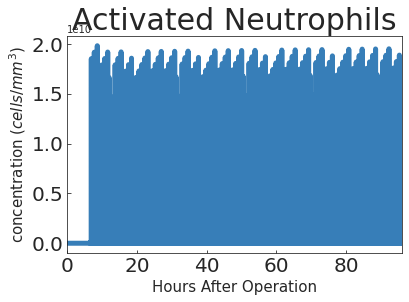

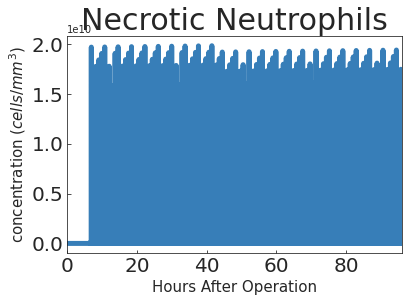

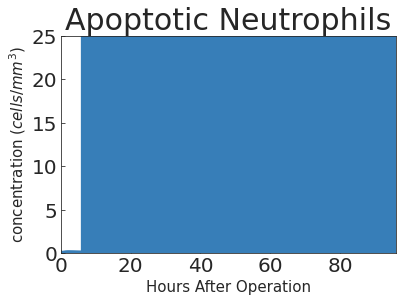

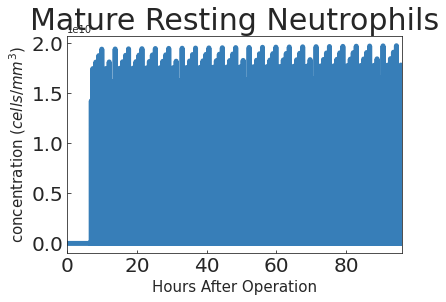

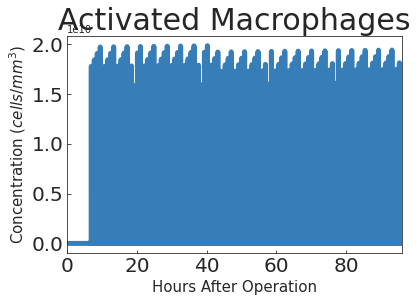

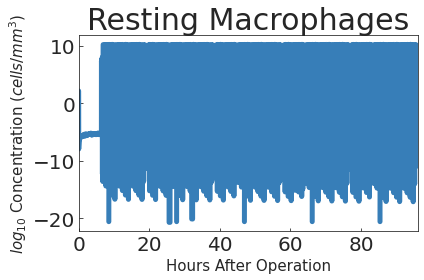

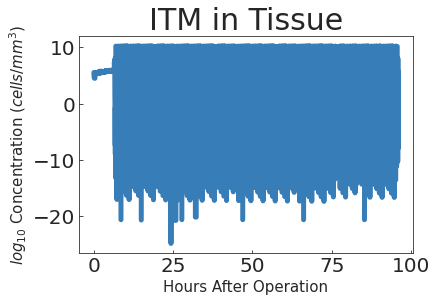

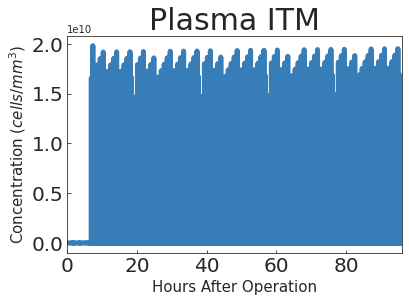

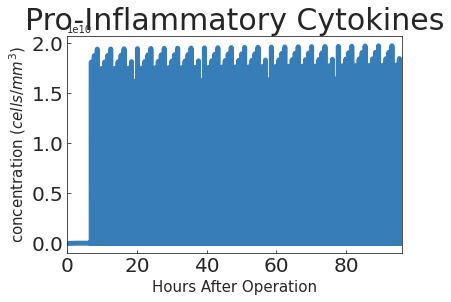

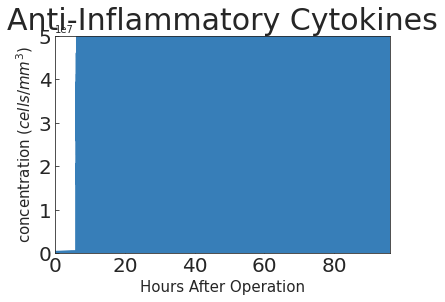

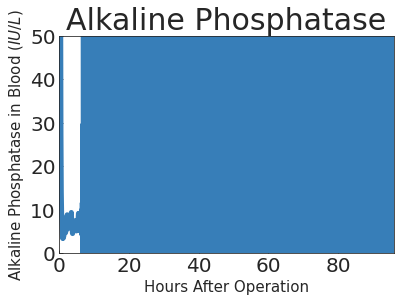

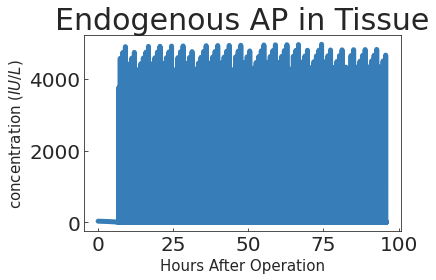

In [41]:
# for case in cases:

add_ITMblood_names = [
    '2e5', '4e5', '6e5', '8e5', '2e6', '4e6', '6e6', '8e6', '2e7', '4e7',
    '6e7', '8e7'
]
slow_names = [
    '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'
]
t_add_names = ['24', '36', '48', '60']
count = 0

phi_MRA = prms.phi_MRA

mu_NR = prms.mu_NR
mu_NA = prms.mu_NA
mu_NDA = prms.mu_NDA
mu_NDN = prms.mu_NDN
mu_APE = prms.mu_APE
mu_APSfast = prms.mu_APSfast
mu_APSslow = prms.mu_APSslow
mu_APS = prms.mu_APS
mu_MA = prms.mu_MA
mu_MR = prms.mu_MR
mu_ACH = prms.mu_ACH
mu_CH = prms.mu_CH
mu_ITM = prms.mu_ITM

lamb_ITMNA = prms.lamb_ITMNA
lamb_APE = prms.lamb_APE
lamb_APS = prms.lamb_APS
lamb_ITMMA = prms.lamb_ITMMA
lamb_MANDA = prms.lamb_MANDA
lamb_MANDN = prms.lamb_MANDN
lamb_ITMNDN = prms.lamb_ITMNDN

Pmax_MR = prms.Pmax_MR
Pmin_MR = prms.Pmin_MR
Pmax_NR = prms.Pmax_NR
Pmin_NR = prms.Pmin_NR
Pmax_ITM = prms.Pmax_ITM
Pmin_ITM = prms.Pmin_ITM

Keq_CH = prms.Keq_CH
Mmax = prms.Mmax
Nmax = prms.Nmax
ACHmax = prms.ACHmax
CHmax_tissue = prms.CHmax_tissue

ITMblood0 = prms.ITMblood0
ITMmax = prms.ITMmax
APEbmax = convert_AP(prms.APEbmax, 'endo', 'tissue')
APElmax = convert_AP(prms.APElmax, 'endo', 'tissue')
APEmax = convert_AP(prms.APEmax, 'endo', 'tissue')
APSmax = convert_AP(prms.APSmax, 'supp', 'blood')

alpha_ITMNDN = prms.alpha_ITMNDN
alpha_ACHMA = prms.alpha_ACHMA
alpha_ACHMA = prms.alpha_ACHMA

beta_CHMA = prms.beta_CHMA
beta_CHNA = prms.beta_CHNA
beta_MANDA = prms.beta_MANDA

theta_ACH = prms.theta_ACH

ITM_source_peak = prms.ITM_source_peak
ITM_source_width = prms.ITM_source_width

# Initial Conditions
N_R0 = prms.N_R0
N_A0 = prms.N_A0
ND_A0 = prms.ND_A0
ND_N0 = prms.ND_N0
M_R0 = prms.M_R0
M_A0 = prms.M_A0
AP_S0 = convert_AP(prms.AP_S0, 'supp', 'blood')
AP_Ebt0 = AP_S0 + APEbmax
AP_St0 = prms.AP_St0
AP_Et0 = convert_AP(prms.AP_Et0, 'endo', 'tissue')
AP_El0 = convert_AP(prms.AP_El0, 'endo', 'blood')
AP_Eb0 = convert_AP(prms.AP_Eb0, 'endo', 'blood') + AP_El0
CH0 = prms.CH0
ACH0 = prms.ACH0
N_B0 = prms.N_B0

AP_Sinj = (1 * 5.6 * 80.) / (60. * 5)
AP_Sinj = convert_AP(AP_Sinj, 'supp', 'blood')

step_max = prms.step_max

step = 'bIAP'
bound = 'bound_'
norm = 'norm_'
params = {'h': 'h4', 'restrict': False}

beta_CHMA = 7.8e-4
beta_CHNA = 4.8e-2
theta_ACH = 1e-10
beta_MANDA = 9e1
lamb_ITMNDN = 1.e-6
alpha_ITMNDN = 1e3
Pmax_APE = 0.002
Pmin_APE = 0.0002
rdistress = 3e6  # 1e6
w_gauss_min = 8e7
rinduce_peak = 21.0
rinduce = 0.05
r_AP = 0.08
r_ITM = 0.5
r_ITMpeak = 5 * 10**12
r_NDN = 0.008
lamb_MANDN = 5e-6
lamb_MANDA = 3e-5
mu_NDA = 2.5e1
Keq_CH = 2e4
r_Nhomeo = 1e-4
Pmax_NR = 6e-3

r_APhomeo = Pmin_APE + prms.mu_APE

time = prms.time
t = [
    prms._stoptime * float(i) / (prms._numpoints - 1)
    for i in range(prms._numpoints)
]
ITMtissue0 = prms.ITMtissue0
ITMtrans0 = prms.ITMtrans0
AP_filename = prms.AP_fle
pred_filename = prms.pred_fle

cyto_fle = prms.cyto_fle
sample_fle = prms.sample_fle
trt_fle = prms.trt_fle
german_hospital_file = prms.german_hospital_file
dutch_hospital_file = prms.dutch_hospital_file
treatment_file = prms.treatment_file

# case 5 is for placebo experiment
# case 6 is for bIAP experiment
cases = [5]
case_names = ['', '', '', 'No AP', 'Placebo', 'bIAP']
patients = ['16', '51', '36', '26', '59']
treatment = 'Placebo'

df_median, cyto_dic = cyto.get_median(cyto_fle, sample_fle, trt_fle, 'time')
df_IL10 = df_median[df_median['cytokine'] == 'il10']
df_IL6 = df_median[df_median['cytokine'] == 'il6']

df_median_restrict, cyto_dic_restrict = cyto.get_median_restrict(
    cyto_fle,
    sample_fle,
    trt_fle,
    'time',
    treatment=treatment,
    patients=patients)
df_IL10_restrict = df_median_restrict[df_median_restrict['cytokine'] == 'il10']
df_IL6_restrict = df_median_restrict[df_median_restrict['cytokine'] == 'il6']
df_cyto = cyto.get_data(cyto_fle, sample_fle, trt_fle, 'sample')

df_AP, df_AP_median = dp.get_data(german_hospital_file=german_hospital_file,
                                  dutch_hospital_file=dutch_hospital_file,
                                  treatment_file=treatment_file,
                                  parameter_name='AlkFosf',
                                  restrict=False,
                                  treatment=treatment,
                                  patients=patients,
                                  do_binning=True)

df_AP_restrict, df_AP_median_restrict = dp.get_data(
    german_hospital_file=german_hospital_file,
    dutch_hospital_file=dutch_hospital_file,
    treatment_file=treatment_file,
    parameter_name='AlkFosf',
    restrict=True,
    treatment=treatment,
    patients=patients,
    do_binning=True)

case = 5

# print ('Combination ', count)
# print ('... Testing add_ITMblood = ',add_ITMblood)
# print ('... Testing slow = ',slow)
# print ('... Testing t_add = ',t_add)
# print ('... Trial ', trial)

add_ITMbloods = [2e5, 4e5, 6e5, 8e5, 2e6, 4e6, 6e6, 8e6, 2e7, 4e7, 6e7, 8e7]
slows = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
t_adds = [24. * 60., 36. * 60., 48. * 60., 60. * 60.]

mu = 0
np.random.seed(10)

add_ITMblood = 5e6
add_ITMblood_name = '5e6'

slow = 0.001
slow_name = '0.001'

t_add = 0.5 * 60.
t_add_name = '0.5'

sig_mult = 0

# noise_type = 'sigmoid'
# noise_type = 'linear'
# noise_type = 'gaussian'
noise_type = 'interval'

# sigma_type = 'increasing'
sigma_type = 'constant'
# sigma_type = 'zero'

### NOISE 1
if noise_type == 'linear':
    add_ITMblood = 1e7
    add_ITMblood_name = '1e7'
    slow = 0.001
    slow_name = '0.001'
    t_add = 1 * 60.
    t_add_name = '1'
    src_strength = 0
    src_width = 0
    if sigma_type == 'constant':
        sig_mult = 1e5
#         sig_mult = 1e6
    elif sigma_type == 'increasing':  # increasing
        #         sig_mult = 60
        sig_mult = 80
    else:
        sigma_mult = 0

# NOISE 2: Sigmoid
elif noise_type == 'sigmoid':
    add_ITMblood = 1e7
    add_ITMblood_name = '1e7'
    slow = 0.001
    slow_name = '0.001'
    t_add = 1 * 60.
    t_add_name = '1'
    src_strength = 0
    src_width = 0
    if sigma_type == 'constant':
        sig_mult = 1e5
#         sig_mult = 1e6
    elif sigma_type == 'increasing':  # increasing
        sig_mult = 60
    else:
        sig_mult = 0

### NOISE 3
elif noise_type == 'gaussian':
    t_add = 80 * 60.
    #     np.random.seed(0)
    #     t_add = 1 * 60.
    src_strength = 3e7
    src_width = 2.2e3
    if sigma_type == 'constant':
                sig_mult = 5e5
#         sig_mult = 9e4
    elif sigma_type == 'increasing':  # increasing
        #         sig_mult = 110
        sig_mult = 120
    else:
        sigma_mult = 0 

### NOISE 3: Sigmoid + interval
elif noise_type == 'interval':
# #continuos
# add_ITMblood = 5e7
# add_ITMblood_name = '5e7'
# slow = 0.001
# slow_name = '0.001'
# t_add = 1 * 60.
# t_add_name = '1'
# sig_mult = 100

    add_ITMblood = 1e7
    add_ITMblood_name = '1e7'
    slow = 0.001
    slow_name = '0.001'
    t_add = 5 * 60.
    t_add_name = '1'
    src_strength = 0
    src_width = 0
    if sigma_type == 'constant':
        sig_mult = 1e5
#         sig_mult = 1e6
    elif sigma_type == 'increasing':  # increasing
        sig_mult = 60
    else:
        sig_mult = 0

sigma = f'sigmoid_{add_ITMblood_name}_{slow_name}_{t_add_name}'
t = [
    prms._stoptime * float(i) / (prms._numpoints - 1)
    for i in range(prms._numpoints)
]

p = [
    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA,
    mu_NDA, mu_NDN, mu_NR, mu_ITM, Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue,
    Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, theta_ACH, lamb_APE,
    lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA,
    beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax,
    rdistress, lamb_ITMNDN, alpha_ITMNDN, Pmax_APE, Pmin_APE, rinduce_peak,
    AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax,
    step_max, r_NDN, r_ITM, r_ITMpeak, r_AP, rinduce, ITM_source_peak,
    ITM_source_width, add_ITMblood, slow, t_add, sig_mult, src_strength,
    src_width
]

w = [
    N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMblood0, ITMtissue0, M_R0,
    M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0
]
params['case'] = case
w0 = get_init(w, params)

t, wsol = solve(p, w0, t, params)

folder = f'../result/plots/noise/{noise_type}/{sigma_type}/'
os.makedirs(folder, exist_ok=True)
plot(wsol, df_AP_median, case_names, time, t, df_IL6, df_IL10, params, folder)

pickle_dir = f'../result/pickle/noise/{noise_type}/{sigma_type}/'
os.makedirs(pickle_dir, exist_ok=True)

pickle_it(pickle_dir, noise_type, sigma_type, wsol, t)
passed = True